In [1]:
import perceval as pcvl
import numpy as np
from collections import Counter
pcvl.__version__

'0.13.0'

# BasicStates

In Linear Optical Circuits, photons can have many discrete degrees of freedom, called modes. 
It can be the frequency, the polarisation, the position, or all of them.

We represent these degrees of freedom with Fock states. If we have $n$ photons over $m$ modes, the Fock state $|s_1,s_2,...,s_m\rangle$ means we have $s_i$ photons in the $i^{th}$ mode. Note that $\sum_{i=1}^m s_i =n$.

In Perceval, we will use the module `pcvl.BasicState`

## Defining and manipulating BasicStates

In [2]:
# BasicState can be constructed from a bra-ket string
state=pcvl.BasicState("|0,1>")
# or from a list
assert(state == pcvl.BasicState([0,1]))
print(state[0], state[1])

0 1


In [3]:
print("type of state is", type(state))
# BasicState will print as a string, state.n is the number of photons, state.m the number of modes (which is also the len of the BasicState)
print(f"state='{state}', n={state.n}, m={state.m}, m={len(state)}")

type of state is <class 'exqalibur.FockState'>
state='|0,1>', n=1, m=2, m=2


<div class="alert alert-info">
Note the type is <code>exqalibur.FockState</code> and not <code>pcvl.BasicState</code>!<br>
&rarr; <code>perceval</code> library is using behind the scene a c++-optimized library <code>exqalibur</code> that is in charge of all the heavy lifting - we never use it directly, but it is where all the simulation work happens!
</div>

In [4]:
# BasicState does not support assignment
try:
    state[0]=1
except Exception as e:
    print("ERROR:", e)

ERROR: 'exqalibur.FockState' object does not support item assignment


In [5]:
# let us define a function that does that!
def assign(state, k, n_k):
    r"""assigns n_k photon in the k-th mode of state, and returns the new BasicState"""
    assert(isinstance(state, pcvl.BasicState))
    assert(n_k < state.m)
    ### ENTER CODE HERE
    state_lst = list(state)
    state_lst[k] = n_k
    new_state = pcvl.BasicState(state_lst)
    ### END CODE
    return new_state

# check if it works
new_state = assign(state, 0, 1)
assert(new_state == pcvl.BasicState("|1,1>"))

## Operations on BasicStates

### tensor product
`*` defines tensor product (`s1*s2` ~ $s_1\otimes s_2$)

In [6]:
print(pcvl.BasicState([0,1])*pcvl.BasicState([2,3]))

|0,1,2,3>


And `**` the tensor power (`s**n` ~ $s^{\otimes n}$), typically useful to initialize an input state

In [7]:
s2 = pcvl.BasicState([0,1])**4
print(s2)

|0,1,0,1,0,1,0,1>


In [8]:
# python slice operator applies smoothly
print(s2[1:4])

|1,0,1>


## State Vectors

A state vector is defined as a general quantum state: $\sum_i \alpha_i.s_i$ where $s_i$ are `BasicState`and $\alpha_i$ their complex parameters/

StateVectors can be build directly with `+`, `-` operators can be used to create state superposition:

In [9]:
sv1 = pcvl.BasicState([0,1])+pcvl.BasicState([1,0])

In [10]:
# this is again an optimized `exqalibur` object!
type(sv1)

exqalibur.StateVector

In [11]:
# let us check the value
print(sv1)

0.707*|1,0>+0.707*|0,1>


So $sv_1=\frac{\sqrt 2}{2}(\ket{1,0}+\ket{0,1})$
<div class="alert alert-info"> Note the <code>sqrt(2)/2</code> that was introduced: what even you are doing on the <code>StateVector</code>, they keep the parameters normalized so that </div> 

$\sum_i |\alpha_i|^2=1$

In [12]:
# one easy way to check this is as follows, the multiplication of a StateVector by a constant does not change its value
assert(2*pcvl.StateVector([0,1])==pcvl.StateVector([0,1]))

except when building a superposed state:

In [13]:
sv2 = pcvl.StateVector([0,1])-2j*pcvl.StateVector([2,3])
print(sv2)

-0.894I*|2,3>+0.447*|0,1>


In [14]:
pcvl.pdisplay(sv2) # you can add nsimplify=False here too!

state,prob. ampl.
"|2,3>",I*-2*sqrt(5)/5
"|0,1>",sqrt(5)/5


Finally, we can iterate manually through the different components of a state vector:

In [15]:
for bs, alpha in sv2:
    # here we invoke manually the number simplification - easier to read
    print(alpha, pcvl.simple_complex(alpha)[1], bs)

(-0-0.8944271909999159j) -2*sqrt(5)*I/5 |2,3>
(0.4472135954999579+0j) sqrt(5)/5 |0,1>


We can combine states with different number of photons (`-2*sqrt(5)*I/5*|2,3>+sqrt(5)/5*|0,1>`) but we cannot combine states with different number of modes - it does not make sense:

In [16]:
try:
    pcvl.BasicState("|0,1>")+pcvl.BasicState("|0,1,2>")
except:
    print("!!! Exception was generated: we cannot have superposed states with different number of modes !!!")

!!! Exception was generated: we cannot have superposed states with different number of modes !!!


In [17]:
# ok - we can now manipulate StateVector - let us define a function giving us the probability of having one or mode photons in a given mode
def photon_probability(sv, mode):
    r"""should return the probability that when we measure `sv`, we observe at least one photon in mode `mode`"""
    assert(mode < sv.m)
    probability = 0
    ### ENTER CODE HERE
    for bs, alpha in sv:
        if bs[mode] >=1:
            probability += abs(alpha)**2
    ### END CODE
    return probability

In [18]:
# let us check this
assert(abs(photon_probability(pcvl.BasicState([0,1])+pcvl.BasicState([1,0]),0)-0.5)<1e-6)
assert(abs(photon_probability(pcvl.BasicState([0,1,0])+pcvl.BasicState([0,1,0]),0)-0)<1e-6)
assert(abs(photon_probability(sv2, 0)-0.8)<1e-6)

Now we can also use built-in `StateVector` methods providing sampling and measurement: 

In [19]:
print(sv2)
c = Counter()
for s in sv2.samples(100): 
    c[s] += 1
print(c)

-0.894I*|2,3>+0.447*|0,1>
Counter({|2,3>: 79, |0,1>: 21})


In [20]:
sv_4 = pcvl.StateVector("|0,1,1>")-1j*pcvl.StateVector("|1,1,0>")
map_measure_sv_4 = sv_4.measure([1])
for s, (p, sv) in map_measure_sv_4.items(): 
    print(s, p, sv)

|1> 0.9999999999999998 0.707*|0,1>-0.707I*|1,0>


In [21]:
map_measure_sv_4 = sv_4.measure([2])
for s, (p, sv) in map_measure_sv_4.items(): 
    print(s, p, sv)

|1> 0.4999999999999999 |0,1>
|0> 0.4999999999999999 -1I*|1,1>


## Modeling of a noisy photon source with a SVDistribution

A `SVDistribution` is a mixed state of `StateVector` - it is commonly used to model noisy photon source.

For that let us use the `pcvl.Source` object, it takes the following parameters:
* `emission_probability`: `float` = 1,
* `multiphoton_component`: `float` = 0,
* `indistinguishability`: `float` = 1,
* `losses`: `float` = 0
  

### Perfect Source

<img src="img/perfect_source.png">

In [22]:
perfect_source = pcvl.Source(emission_probability=1, multiphoton_component=0, indistinguishability=1, losses=0)
pcvl.pdisplay(perfect_source.probability_distribution())

state,probability
|1>,1


<div class="alert alert-info">
    In the perfect case, the source emits a sequence of `|1>`
</div>

### Real World Photon source

<img src="img/realworld_source.png">

In [23]:
realworld_source = pcvl.Source(emission_probability=0.5, multiphoton_component=0.02, indistinguishability=0.95, losses=0.7)
pcvl.pdisplay(realworld_source.probability_distribution())
probability_1photon = 0
for sv, p in realworld_source.probability_distribution().items():
    probability_1photon += photon_probability(sv, 0)*p
print("probability of seing a photon in the output:", probability_1photon)

state,probability
|0>,0.84947
|{_:0}>,0.14598
|{_:1}>,0.004323
|{_:0}{_:2}>,0.000221524
|{_:1}{_:2}>,5.75482e-06


probability of seing a photon in the output: 0.15053031655775084


<div class="alert alert-warning">
    In the real world, with the parameters given to the source, 85% of the time, no photon is detected, 14.5% of the time, single indistinguishable photons are emitted (represented with <code>{_:0}</code>) - and the rest is a combination of g_2 and distinguishable photons
</div>

# LO-Components

The linear optical components are the elementary blocks which will act on our Fock states.

It's important to know all the possible components that can be found in Perceval and understand their effects.

In [24]:
# the components we are interested in are in unitary_components or non_unitary_components
# see https://perceval.quandela.net/docs/components.html for the full list
import perceval.components.unitary_components as pcvl_comp

PERM
PERM([2, 0, 1])


<IPython.core.display.Math object>

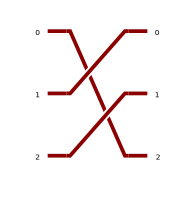

In [25]:
# let us start with permutation - we define permutation by a permutation list
perm_1=pcvl_comp.PERM([2,0,1])
# name of the component
print(perm_1.name)
# the definition of the component
print(perm_1.describe())
# the unitary matrix
pcvl.pdisplay(perm_1.definition())
# and the visual representation
pcvl.pdisplay(perm_1)

In [26]:
# let us define a function generating the permutation inverting first and last mode
def invert_first_last(m):
    ## ENTER CODE HERE
    perm = pcvl_comp.PERM([m-1]+[mode for mode in range(1,m-1)]+[0])
    ## END_CODE
    return perm


the unitary:


<IPython.core.display.Math object>

the circuit:


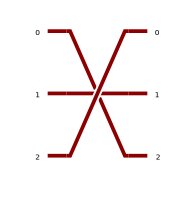

In [27]:
perm_2 = invert_first_last(3)
print("the unitary:")
U_perm_2=perm_2.compute_unitary()
assert(U_perm_2[0,0]==0)
assert(U_perm_2[0,1]==0)
assert(U_perm_2[0,2]==1)
assert(U_perm_2[1,0]==0)
assert(U_perm_2[1,1]==1)
assert(U_perm_2[1,2]==0)
assert(U_perm_2[2,0]==1)
assert(U_perm_2[2,1]==0)
assert(U_perm_2[2,2]==0)
pcvl.pdisplay(U_perm_2)
print("the circuit:")
pcvl.pdisplay(perm_2)

BS(Rx)
BS.Rx()


<IPython.core.display.Math object>

<IPython.core.display.Math object>

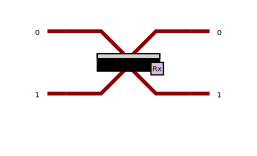

In [28]:
# let us do the same with beamsplitters !
bs=pcvl_comp.BS()
# name of the component
print(bs.name)
# the definition of the component
print(bs.describe())
# the unitary matrix
pcvl.pdisplay(bs.definition())
# the actual unitary matrix
pcvl.pdisplay(bs.compute_unitary())
# the visual representation
pcvl.pdisplay(bs)

BS.Rx() unitary matrix


<IPython.core.display.Math object>

BS.H() unitary matrix


<IPython.core.display.Math object>

BS.Ry() unitary matrix


<IPython.core.display.Math object>

BS displays its convention as a small label


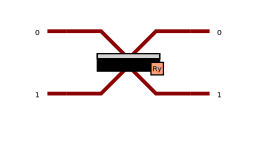

In [29]:
bs_rx = pcvl_comp.BS.Rx()  # By default a beam splitter follows the Rx gate convention (see documentation), so bs=BS() has the same matrix

# But other conventions exist too:
bs_h = pcvl_comp.BS.H() 
bs_ry = pcvl_comp.BS.Ry()

## Check the difference in the unitary definition:
print("BS.Rx() unitary matrix")
pcvl.pdisplay(bs_rx.definition())
print("BS.H() unitary matrix")
pcvl.pdisplay(bs_h.definition())
print("BS.Ry() unitary matrix")
pcvl.pdisplay(bs_ry.definition())
print("BS displays its convention as a small label")
pcvl.pdisplay(bs_ry)

In [30]:
# You can ask for the symbolic matrix value of your component with the attribute U
my_ps = pcvl_comp.PS(phi=np.pi/8)
pcvl.pdisplay(my_ps.U)
# And for the numerical value with the method compute_unitary
pcvl.pdisplay(my_ps.compute_unitary())
print("")

# If you do it for a Beam-Splitter, you can see that by default theta=pi/2, and the phi's are 0
print("A default beam-splitter:")
pcvl.pdisplay(pcvl_comp.BS().compute_unitary())  #this is a balanced Beamsplitter
print("")

# To control the value of the parameters of a component, several choices are possible: 
#  - by setting a numerical value during the creation of the component
print("A Beam-Splitter with a numerical value for theta:")
bs_rx = pcvl_comp.BS.Rx(theta=10)
pcvl.pdisplay(bs_rx.U)
pcvl.pdisplay(bs_rx.compute_unitary())
print("")

<IPython.core.display.Math object>

<IPython.core.display.Math object>


A default beam-splitter:


<IPython.core.display.Math object>


A Beam-Splitter with a numerical value for theta:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [31]:
#  - by using the syntax pcvl.P to create a symbolic variable 
#    (note that you cannot compute the numerical value of your component anymore)
print("A Phase Shifter with a symbolic value for phi:")
ps = pcvl_comp.PS(phi=pcvl.P('\psi'))
pcvl.pdisplay(ps.U)
print("")

#  - you can still modify the value of a symbolic variable after its creation
#    This is not true for a numerical variable!
print("A beam-splitter with a symbolic variable...")
bs_rx = pcvl_comp.BS(theta=pcvl.P('a'))
pcvl.pdisplay(bs_rx.U)
bs_rx.assign({'a':10})
print("... set to a numerical value")
pcvl.pdisplay(bs_rx.compute_unitary())
print("")

A Phase Shifter with a symbolic value for phi:


<IPython.core.display.Math object>


A beam-splitter with a symbolic variable...


<IPython.core.display.Math object>

... set to a numerical value


<IPython.core.display.Math object>

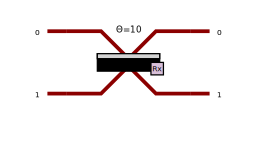

In [32]:
pcvl.pdisplay(bs_rx)

# LO-Circuits

From the LO-components, we can build a LO-circuit, i.e. a sequence of those components acting on our different modes.

## Syntax

<IPython.core.display.Math object>

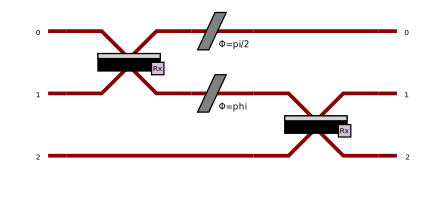

In [33]:
circuit = pcvl.Circuit(3)  # Create a 3 mode circuit


circuit.add(0, pcvl_comp.BS())
circuit.add(0, pcvl_comp.PS(phi=np.pi/2)).add(1, pcvl_comp.PS(phi=pcvl.P('phi'))).add(1, pcvl_comp.BS())

# Equivalent syntax:
# circuit // BS() // PS(phi=np.pi/2) // (1, PS(phi=pcvl.P('phi'))) // (1, BS())

pcvl.pdisplay(circuit.U)
pcvl.pdisplay(circuit)

The syntax ``pcvl.P('phi')`` allows you to use parameters in the circuit, where you can assign a value or not. The behavior of the parameters of a circuit is similar to the case of the components.

For instance, you can use :

[Parameter(name='phi', value=None, min_v=0.0, max_v=6.283185307179586)]


<IPython.core.display.Math object>

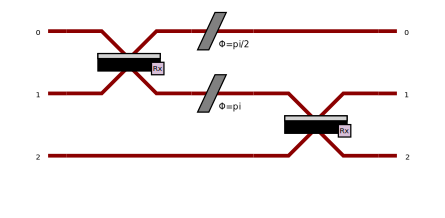

In [34]:
params=circuit.get_parameters()
print(params) #list of the parameters

# the value is None, but we can change that with :

params[0].set_value(np.pi)
pcvl.pdisplay(circuit.compute_unitary(use_symbolic=False))
pcvl.pdisplay(circuit)

<IPython.core.display.Math object>

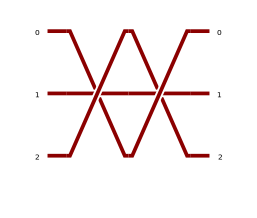

In [35]:
# let us combine perm_2 with perm_2 to build identity
circuit = perm_2 // perm_2
pcvl.pdisplay(circuit.U)
pcvl.pdisplay(circuit)

## Mach-Zehnder Interferometers

The beamsplitter's angle $\theta$ can also be defined as a parameter.

However, as the reflexivity depends on the mirror, it's hard to have adaptibility on the angle. 
Therefore, in practice, we use a [Mach-Zehnder Interferometer](https://en.wikipedia.org/wiki/Mach%E2%80%93Zehnder_interferometer). 

The beamsplitter with a parameterised $\theta$ is therefore implemented with a parameterised phase shifter $\phi$ between two fixed beamsplitters.

Let us try to reproduce the experiment from the presentation:
<img src="img/mzi.png">


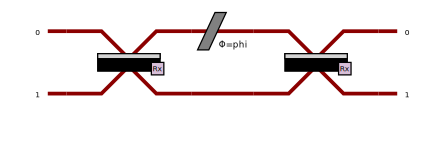

In [36]:
# Define the variable `mzi`to be a circuit implementing this schema. We want the phase-shifter on the top arm to be a parameter with 'phi' value
### ENTER CODE HERE
mzi = pcvl.Circuit(2) // pcvl.BS() // pcvl.PS(phi=pcvl.P('phi')) // pcvl.BS()
### END CODE
pcvl.pdisplay(mzi)

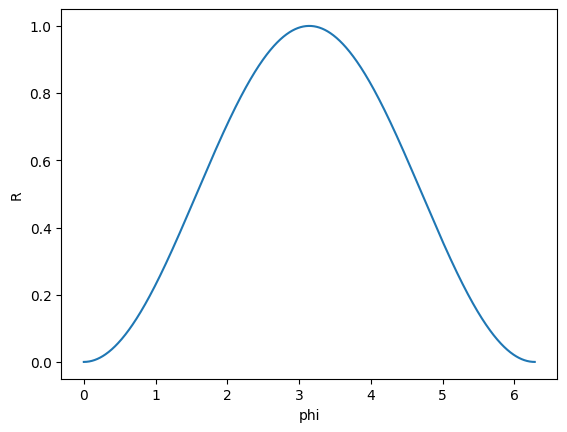

In [37]:
import matplotlib.pyplot as plt

## We create a list of all different values for phi in the range [0,2*pi[
X = np.linspace(0, 2*np.pi, 1000)
Y = []
for phi in X:
    phase = mzi.get_parameters()[0]
    phase.set_value(phi)
    # we are interested in mzi.compute_unitary()[0,0] which is the probability of detecting a photon in first output mode while sending in one photon into the first input mode.
    Y.append(abs(mzi.compute_unitary()[0,0])**2)
   
plt.plot(X, Y)
plt.xlabel("phi")
plt.ylabel("R")
plt.show()

## Universal Circuits

An operation on the modes of our circuit can also be expressed as a unitary.

For three modes, the unitary $U=\begin{pmatrix}
a_{1,1} & a_{1,2} & a_{1,3}\\
a_{2,1} & a_{2,2} & a_{2,3} \\ 
a_{3,1} & a_{3,2} & a_{3,3}
\end{pmatrix}$ performs the following operation on the Fock state basis:

$$\begin{array}{rcl}
|1,0,0\rangle &  \mapsto&  a_{1,1}|1,0,0\rangle + a_{1,2}|0,1,0\rangle + a_{1,3}|0,0,1\rangle\\
|0,1,0\rangle &  \mapsto&  a_{2,1}|1,0,0\rangle + a_{2,2}|0,1,0\rangle + a_{2,3}|0,0,1\rangle\\
|0,0,1\rangle &  \mapsto&  a_{3,1}|1,0,0\rangle + a_{3,2}|0,1,0\rangle + a_{3,3}|0,0,1\rangle
\end{array}$$

Since 1994, we know that any $U$ on the modes can be implemented as an LO-circuit [Reck's et al](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.73.58).

This decomposition can be done easily in Perceval using beamsplitters and phase-shifters as follows. 

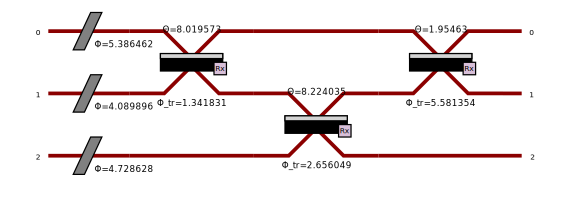

In [38]:
## From any unitary
n = 3
U = pcvl.Matrix.random_unitary(n)

circuit_u = pcvl.Circuit.decomposition(U, pcvl_comp.BS(theta=pcvl.P('theta'),phi_tr=pcvl.P('phi')), phase_shifter_fn=pcvl_comp.PS)

pcvl.pdisplay(circuit_u)

In [39]:
print("The distance between the two unitaries is", np.linalg.norm(U-circuit_u.compute_unitary()))

The distance between the two unitaries is 6.774944867428865e-09


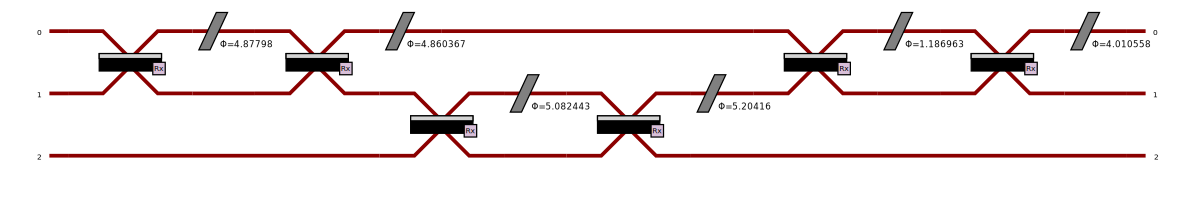

In [40]:
# do the same, but do not use a parameterable beamsplitter, but rather a mzi as defined here
mzi=pcvl.Circuit(2) // pcvl_comp.BS() // pcvl_comp.PS(pcvl.P("phi1")) //  pcvl_comp.BS()  //  pcvl_comp.PS(pcvl.P("phi2"))

### ENTER CODE HERE
circuit_u_2 = pcvl.Circuit.decomposition(U, mzi) 
### END CODE

pcvl.pdisplay(circuit_u_2)

In [41]:
print("The distance between the two unitaries is", np.linalg.norm(U-circuit_u_2.compute_unitary()))

The distance between the two unitaries is 2.0212956084436677


## Black Box

To improve readibility, the circuit can be constructed in multiple steps which are then combined as black boxes. This will also help when we'll need generic operations.


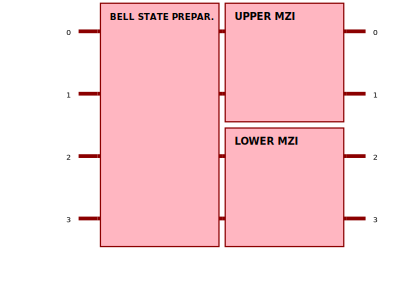

In [42]:
pre_MZI = (pcvl.Circuit(4, name="Bell State Prepar.")
           .add(0, pcvl_comp.BS())
           .add(2, pcvl_comp.BS())
           .add(1, pcvl_comp.PERM([1, 0])))

upper_MZI = (pcvl.Circuit(2, name="upper MZI")
             .add(0, pcvl_comp.PS(phi=pcvl.P('phi_0')))
             .add(0, pcvl_comp.BS())
             .add(0, pcvl_comp.PS(phi=pcvl.P('phi_2')))
             .add(0, pcvl_comp.BS()))

lower_MZI = (pcvl.Circuit(2, name="lower MZI")
             .add(0, pcvl_comp.PS(phi=pcvl.P('phi_1')))
             .add(0, pcvl_comp.BS())
             .add(0, pcvl_comp.PS(phi=pcvl.P('phi_3')))
             .add(0, pcvl_comp.BS()))

chip = (pcvl.Circuit(4)
              .add(0, pre_MZI)
              .add(0, upper_MZI, merge=False)
              .add(2, lower_MZI, merge=False))

pcvl.pdisplay(chip)

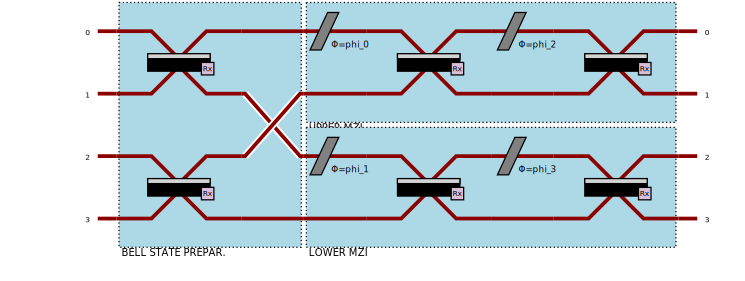

In [43]:
## You can still display the inside of black boxes with:
pcvl.pdisplay(chip, recursive=True)

# Simulation

Up to this point, we have focused on creating circuits.
It's time to learn how to sample from them or describe their output distribution, on many different inputs.

## HOM

For this part, we will take the [Hong-Ou-Mandel](https://en.wikipedia.org/wiki/Hong%E2%80%93Ou%E2%80%93Mandel_effect) experience as an example.

It's one of the simplest experiments and yet it is very useful.

Using two indistinguishable photons, one in each mode, enter one balanced beamsplitter $BS=\frac{1}{\sqrt{2}} \left[\begin{matrix}1 & 1\\1& -1\end{matrix}\right]$, we expect the outcome to be:

$$|1,1\rangle \mapsto \frac{|2,0\rangle - |0,2\rangle}{\sqrt{2}}$$

If the two photons are completely distinguishable, then we expect the two photons to have independent journey through the beamsplitter thus generating 3 possible states $|2,0\rangle$ and $|0,2\rangle$ with 25% probability each and $|1,1\rangle$ with 50% chance probability.

<img src="img/indistinguishability.png" width=50%>

We will show how to verify this in the next steps using the different backends and tools available in Perceval.

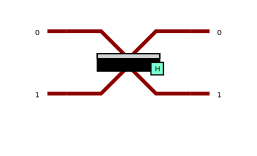

In [44]:
# The circuit is simply the following
circuit_hom = pcvl.Circuit(2) // pcvl_comp.BS.H()
pcvl.pdisplay(circuit_hom)

## Using Backends
Backends are the computation primitive as defined here: <a src="https://perceval.quandela.net/docs/backends.html">https://perceval.quandela.net/docs/backends.html</a>.

Backends may implement the following method:
* `prob_amplitude` and `probability` - only for strong simulation
* `sample` - only for weak simulation `CliffordClifford2017`
#### Getting probability distribution or samples with computing backend

In [45]:
for backend_name in ["Naive", "SLOS", "CliffordClifford2017"]:
    backend = pcvl.BackendFactory.get_backend(backend_name)
    backend.set_circuit(circuit_hom)
    backend.set_input_state(pcvl.BasicState([1,1]))
    print("----", backend_name, "backend")
    all_states = [pcvl.BasicState([0,2]), pcvl.BasicState([1,1]), pcvl.BasicState([2,0])]
    for bs in all_states:
        try:
            print(f"\tprob_ampli({bs})={pcvl.simple_complex(backend.prob_amplitude(bs))[1]:10}\tprob({bs})={pcvl.simple_float(backend.probability(bs))[1]}")
        except:
            print(f"\tprob_ampli({bs})={'N/A':10}\tprob({bs})=N/A")
    try:
        samples = [backend.sample() for _ in range(10)]
    except:
        samples = "N/A"
    print(f"\t10 samples={samples}")

---- Naive backend
	prob_ampli(|0,2>)=-sqrt(2)/2	prob(|0,2>)=1/2
	prob_ampli(|1,1>)=0         	prob(|1,1>)=0
	prob_ampli(|2,0>)=sqrt(2)/2 	prob(|2,0>)=1/2
	10 samples=N/A
---- SLOS backend
	prob_ampli(|0,2>)=-sqrt(2)/2	prob(|0,2>)=1/2
	prob_ampli(|1,1>)=0         	prob(|1,1>)=0
	prob_ampli(|2,0>)=sqrt(2)/2 	prob(|2,0>)=1/2
	10 samples=N/A
---- CliffordClifford2017 backend
	prob_ampli(|0,2>)=N/A       	prob(|0,2>)=N/A
	prob_ampli(|1,1>)=N/A       	prob(|1,1>)=N/A
	prob_ampli(|2,0>)=N/A       	prob(|2,0>)=N/A
	10 samples=[|0,2>, |2,0>, |0,2>, |2,0>, |2,0>, |2,0>, |2,0>, |0,2>, |2,0>, |2,0>]


#### Getting State Vector with Stepper

While a backend is applying a circuit as a whole and produce probability amplitudes from which we can build output state vectors, or sample list, there are some cases, where we want to direct see the evolution of a state vector through individual components of a circuit - in such case, we will be using a new concept: the "stepper". This is an elegant operation, but it obviously does not scale, since the number of components of a state vector grows exponentially with the number of modes/photons. However, for small circuit, it gives a very simple debugging tool.

In [46]:
stepper = pcvl.simulators.Stepper(pcvl.backends.SLOSBackend())
stepper.set_circuit(circuit_hom)
sv = pcvl.StateVector([1,1])

# we make the state vector evolve through all components of the circuit - here there is only one component
for r, c in circuit_hom:
    sv = stepper.apply(sv, r, c)

print("final state vector", sv)

final state vector -0.707*|0,2>+0.707*|2,0>


## Using Processors

Backends give access to the mathematical primitives allowing to simulate evolution of a states through a circuit. However, it does not really illustrate what one would directly get from an hardware QPU - only able to produce sequence of "samples". For that, we use the concept of `Processor`.

A processor can be using a local backend, or use a remote processor available on the cloud.

In this section, we show how we can use a Processor to get closer to actual hardware programming, also taking into account a real source, threshold detector, circuit loss, ... 

### Sampling with Processor

In [47]:
p = pcvl.Processor("SLOS", circuit_hom)
p.with_input(pcvl.BasicState([1,1]))

# The sampler holds 'probs', 'sample_count' and 'samples' calls. You can use the one that fits your needs!
sampler = pcvl.algorithm.Sampler(p)  
sample_count = sampler.sample_count(1000)
print(sample_count['results'])

{
  |0,2>: 498
  |2,0>: 502
}


### Using Analyzer algorithm

Processor gives access to a variety of algorithms allowing to analyze results 

In [48]:
# built-in Analyzer algorithm is building the "truth-table" of a circuit - ie the probability distribution of output states given a list of input_states
p = pcvl.Processor("Naive", circuit_hom)
analyzer = pcvl.algorithm.Analyzer(p, all_states, all_states)
pcvl.pdisplay(analyzer)

,"|0,2>","|1,1>","|2,0>"
"|0,2>",1/4,1/2,1/4
"|1,1>",1/2,0,1/2
"|2,0>",1/4,1/2,1/4


## Sampling on a random unitary


In [49]:
# Let us do the same for the random 3x3 matrix with 2 photon inputs on mode 0 and 1

randU=pcvl.Unitary(pcvl.Matrix.random_unitary(3))   
input=pcvl.BasicState([1,1,0])

# Define processor and input

### ENTER CODE HERE
p=pcvl.Processor("CliffordClifford2017",randU)
p.with_input(pcvl.BasicState([1,1,0]))
### END CODE

sampler = pcvl.algorithm.Sampler(p)  
sample_count = sampler.sample_count(10000)
print(sample_count['results'])

## Question: how many states do we have for 3 modes and 2 photons?
## There are 6 different states


## Question : how many states do we have for m modes and n photons? 
## There are m+n-1 choose n different states. Cf Bar and Star problems.

{
  |0,0,2>: 1188
  |1,1,0>: 2423
  |2,0,0>: 516
  |0,1,1>: 696
  |0,2,0>: 3279
  |1,0,1>: 1898
}


Note : to approximate with decent precision a distribution over $M$ different states, we would need $M^2$ samples. This can be shown by [Hoeffding's inequality](https://en.wikipedia.org/wiki/Hoeffding%27s_inequality). 

## Sampling with real world source

In the precedent cells, we have simulated a quantum processor using a perfect source, `Processor` initialization takes a third parameter which is a `Source` object as defined above

In [50]:
# Run the sampling again on the random unitary, but setting a real world source - compare the results

### ENTER CODE HERE
noise_model = pcvl.NoiseModel(indistinguishability=0.9, g2=0.04,  transmittance=0.05)
p = pcvl.Processor('SLOS', randU, noise=noise_model)
p.min_detected_photons_filter(0)  # Do not filter out any output state
p.with_input(input)
### END CODE

sampler_realworld = pcvl.algorithm.Sampler(p)  
sample_count_realworld = sampler_realworld.sample_count(10000)

print(sample_count_realworld['results'])

{
  |0,0,1>: 220
  |0,1,0>: 451
  |0,0,0>: 9068
  |0,1,1>: 2
  |1,0,1>: 6
  |1,1,0>: 6
  |1,0,0>: 244
  |0,0,2>: 3
}


<div class="alert alert-warning">
Most of the sample we get have less than 2 photons! It is normal since we are using a photon source in high-loss regime, but this is clearly ruining our statistics
</div>

### Using real world source and threshold detector

So far, we supposed that we could make a difference in the difference between 1 and 2 photons when measuring output states. This is not for granted: a "normal" SNSPD detector is called "Threshold detector" and will only be able to make a difference and more photons. Ideal detector is in contrast called "Photon Number Resolving" (PNR). Let suppose that we have real world detectors.

In [51]:
# we simulate detector unable to make a difference between 1 and more photons
p.thresholded_output(1)

sampler_realworld_2 = pcvl.algorithm.Sampler(p)  
sample_count_realworld_2 = sampler_realworld_2.sample_count(10000)
print(sample_count_realworld_2['results'])

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
{
  |0,0,1>: 230
  |0,1,0>: 492
  |1,0,1>: 3
  |1,1,0>: 6
  |1,0,0>: 254
  |0,1,1>: 3
  |0,0,0>: 9012
}


<div class="alert alert-info">
As expected, we don't have anymore information about states with 2 photon in the same mode - for now, it is the same than observing 1 photon. 
</div>

Let us see how all of that impacts the HOM experiment...

In [52]:
# we are taking a real photon source and will evaluate the ratio of "|1,1>" event (/total number of event where we detect a photon)

import matplotlib.pyplot as plt

## We create a list of all different values for indistinguishability in the range [0,1]
X = np.linspace(0, 1, 1000)
Y = []
for indistinguishability in X:
    realworld_source = pcvl.NoiseModel(transmittance=0.5, g2=0.05, indistinguishability=indistinguishability)
    p = pcvl.Processor("SLOS", circuit_hom, noise=realworld_source)
    p.with_input(pcvl.BasicState([1,1]))
    p.thresholded_output(1)
    p.min_detected_photons_filter(0)  # Do not filter out any output state, will be explained later
    sampler_realworld_2 = pcvl.algorithm.Sampler(p)  
    sample_count_realworld_2 = sampler_realworld_2.sample_count(10000)
    # append in Y the ratio #|1,1> / total number of event where we detect a photon
    ### ENTER CODE HERE
    Y.append(sample_count_realworld_2['results'][pcvl.BasicState('|1,1>')]/10000)
    ### END CODE
plt.plot(X, Y)
plt.xlabel("indistinguishability")
plt.ylabel("ratio of double click")
plt.show()

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecat

KeyboardInterrupt: 

<div class="alert alert-info">We now see the direct relation between the indistinguishability and the ratio of double click - even if it does not reach 0 due to multi-photon component...</div>